## Libraries

In [25]:
import pandas as pd # data processing
from sklearn.model_selection import train_test_split  # data split
from sklearn.preprocessing import LabelEncoder #encoding categorical variable
from sklearn.linear_model import Lasso #least absolute shrinkage and selection operator
from sklearn.feature_selection import RFE #Recursive Feature Elimination
from sklearn.metrics import classification_report  # evaluation metric
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Random forest tree algorithm # XGBoost algorithm
import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization
from termcolor import colored as cl # text customization
from sklearn.metrics import accuracy_score # evaluation metric



## Load dataset

In [26]:
df = pd.read_csv('frd_sample.csv')

In [27]:
#Check the data
df.head(5)

,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD
0,20160801 00:01,1,MOBILE-APP,Y,user260,86.132.25.214,ISP7,USA,payee48,CHN,2,G
1,20160801 00:05,2,WEB,N,user48,113.136.87.62,ISP8,GBR,payee2,YEM,20,G
2,20160801 00:07,3,MOBILE-APP,N,user181,94.97.9.208,ISP16,CHN,payee79,RUS,10,G
3,20160801 00:08,4,WEB,N,user242,170.245.72.244,ISP12,USA,payee33,RUS,20,G
4,20160801 00:08,5,MOBILE-BROWSER,N,user281,124.83.40.103,ISP29,CHN,payee5,CHN,90000,G


In [28]:
df.shape

(3300, 12)

In [29]:
#Check data properties
print(df.dtypes)

EVENT_TIME          object
EVENT_ID             int64
CHANNEL             object
CHALLENGE_RESULT    object
USER_ID             object
IP_ADDRESS          object
ISP                 object
USER_COUNTRY        object
PAYEE_ID            object
PAYEE_COUNTRY       object
AMOUNT               int64
IS_FRAUD            object
dtype: object


In [30]:
print(df.describe())

          EVENT_ID         AMOUNT
count  3300.000000    3300.000000
mean   1650.500000   11704.017273
std     952.772271   24962.562491
min       1.000000       1.000000
25%     825.750000      10.000000
50%    1650.500000     400.000000
75%    2475.250000    6000.000000
max    3300.000000  100000.000000


In [31]:
#check duplicate
df.duplicated().any() 

False

In [32]:
#check null values in dataset
null_counts = df.isnull().sum()  
null_counts[null_counts > 0].sort_values(ascending=False)
null_counts

EVENT_TIME          0
EVENT_ID            0
CHANNEL             0
CHALLENGE_RESULT    0
USER_ID             0
IP_ADDRESS          0
ISP                 0
USER_COUNTRY        0
PAYEE_ID            0
PAYEE_COUNTRY       0
AMOUNT              0
IS_FRAUD            0
dtype: int64

## Data transformation/pre-processing

In [33]:
# Convert the EVENT_TIME to datetime format
df['EVENT_TIME'] = pd.to_datetime(df['EVENT_TIME'], format='%Y%m%d %H:%M')

In [34]:
df['EVENT_TIME']

0      2016-08-01 00:01:00
1      2016-08-01 00:05:00
2      2016-08-01 00:07:00
3      2016-08-01 00:08:00
4      2016-08-01 00:08:00
               ...        
3295   2016-08-06 23:53:00
3296   2016-08-06 23:56:00
3297   2016-08-06 23:56:00
3298   2016-08-06 23:57:00
3299   2016-08-06 23:59:00
Name: EVENT_TIME, Length: 3300, dtype: datetime64[ns]

In [35]:
# Encode IS_FRAUD to binary format
df['IS_FRAUD'] = df['IS_FRAUD'].map({'G': 0, 'F': 1})
df['CHALLENGE_RESULT'] = df['CHALLENGE_RESULT'].map({'Y': 1, 'N': 0})


In [36]:
df1 =df

In [37]:
# Encode categorical columns
label_encoders = {}
for column in ['CHANNEL', 'USER_ID', 'IP_ADDRESS', 'ISP', 'USER_COUNTRY', 'PAYEE_ID', 'PAYEE_COUNTRY']:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])
    label_encoders[column] = le

In [38]:
Total_transactions = len(df1)
normal = len(df1[df1.IS_FRAUD == 0])
fraudulent = len(df1[df1.IS_FRAUD == 1])
fraud_percentage = round(fraudulent/normal*100, 2)
print(cl('Total number of Trnsactions are {}'.format(Total_transactions), attrs = ['bold']))
print(cl('Number of Normal Transactions are {}'.format(normal), attrs = ['bold']))
print(cl('Number of fraudulent Transactions are {}'.format(fraudulent), attrs = ['bold']))
print(cl('Percentage of fraud Transactions is {}'.format(fraud_percentage), attrs = ['bold']))

Total number of Trnsactions are 3300
Number of Normal Transactions are 3000
Number of fraudulent Transactions are 300
Percentage of fraud Transactions is 10.0


In [39]:
#Check the data
df1.head(5)

,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD
0,2016-08-01 00:01:00,1,0,1,179,2424,27,30,43,0,2,0
1,2016-08-01 00:05:00,2,2,0,413,150,28,4,12,32,20,0
2,2016-08-01 00:07:00,3,0,0,91,2534,7,1,77,5,10,0
3,2016-08-01 00:08:00,4,2,0,159,756,3,30,27,5,20,0
4,2016-08-01 00:08:00,5,1,0,202,260,21,1,45,0,90000,0


## Feature engineering and correlation (Automated)

In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   EVENT_TIME        3300 non-null   datetime64[ns]
 1   EVENT_ID          3300 non-null   int64         
 2   CHANNEL           3300 non-null   int32         
 3   CHALLENGE_RESULT  3300 non-null   int64         
 4   USER_ID           3300 non-null   int32         
 5   IP_ADDRESS        3300 non-null   int32         
 6   ISP               3300 non-null   int32         
 7   USER_COUNTRY      3300 non-null   int32         
 8   PAYEE_ID          3300 non-null   int32         
 9   PAYEE_COUNTRY     3300 non-null   int32         
 10  AMOUNT            3300 non-null   int64         
 11  IS_FRAUD          3300 non-null   int64         
dtypes: datetime64[ns](1), int32(7), int64(4)
memory usage: 219.3 KB


##### Reason to consider  feature like: 'USER-ID', 'IP_Address', 'PAYEE_ID'

In [41]:
## 'USER_ID': This might be useful if certain users are more likely to experience fraudulent transactions. 
##            If there is no such correlation, including this feature might only introduce noise in the data.

## 'IP_ADDRESS': This might be useful because fraudulent transactions might be more likely from certain IP addresses. 
##               However, as IP addresses can be easily changed, this feature might not always be reliable.
##                In addition, IP addresses are high-dimensional categorical data, and directly using them might be 
##                impractical due to the potential huge number of unique IPs. A better way could be mapping them 
##                to lower-dimensional data like countries or regions.

## 'ISP': Similar to IP addresses, some ISPs might be more common for fraudulent transactions. 
##        Again, this depends on the nature of your data.

## 'PAYEE_ID': If some payees are more commonly targeted, this might be a useful feature.

##### Correction

In [42]:
#Correlation of Variables .

C:\Users\ronal\AppData\Local\Temp\ipykernel_19620\3935839824.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df1.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

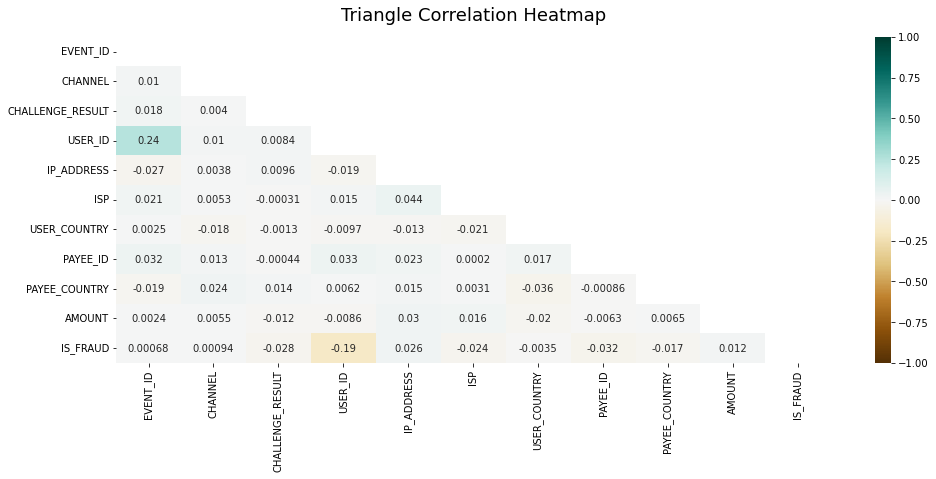

In [43]:
import numpy as np
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df1.corr(), dtype=np.bool))
heatmap = sns.heatmap(df1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [44]:
# Conclusion: No strong evidence to keep/remove specific feature

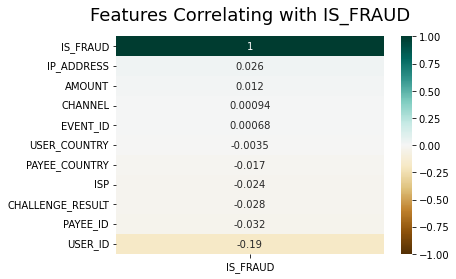

In [45]:
#Correlation of Independent Variables with the Dependent Variable
heatmap = sns.heatmap(df1.corr()[['IS_FRAUD']].sort_values(by='IS_FRAUD', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with IS_FRAUD', fontdict={'fontsize':18}, pad=16);

In [46]:
# Here we are calculating correlations to IS_FRAUD feature for simplicity
correlations = df1.corr()['IS_FRAUD'].sort_values(ascending=False)
print(correlations)

IS_FRAUD            1.000000
IP_ADDRESS          0.025561
AMOUNT              0.011687
CHANNEL             0.000938
EVENT_ID            0.000685
USER_COUNTRY       -0.003522
PAYEE_COUNTRY      -0.016743
ISP                -0.023959
CHALLENGE_RESULT   -0.028165
PAYEE_ID           -0.031555
USER_ID            -0.186879
Name: IS_FRAUD, dtype: float64


In [47]:
# Conclusion: We can see there is not strong evidence which features is highly correlated to the dependent variable(IS_FRAUD).

##### Feature selection

In [48]:
# We are appyling feature selection using models which can provide feature importance, such as Lasso, Random Forest, or Gradient Boosting

In [49]:
df1 = df1.drop(['EVENT_TIME'], axis=1)

# Split the data into training and testing datasets
train_df = df1.iloc[:2200]
test_df = df1.iloc[2200:]


## traning and testing
X_train = train_df.drop('IS_FRAUD', axis=1)
y_train = train_df['IS_FRAUD']
X_test = test_df.drop('IS_FRAUD', axis=1)
y_test = test_df['IS_FRAUD']

# Define predictors (X) and target (y)
X = train_df.drop('IS_FRAUD', axis=1) #predictors
y = train_df['IS_FRAUD'] #target

#Embeded feature selection method
# Fit Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Fit Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_importance = rf.feature_importances_

# Fit Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_importance = gb.feature_importances_

In [50]:
# Print feature importance
print("Lasso Coefficients:")
for feature, coef in zip(X.columns, lasso_coef):
    print(f"{feature}: {coef}")
    
print("\nRandom Forest Feature Importance:")
for feature, importance in zip(X.columns, rf_importance):
    print(f"{feature}: {importance}")

print("\nGradient Boosting Feature Importance:")
for feature, importance in zip(X.columns, gb_importance):
    print(f"{feature}: {importance}")

Lasso Coefficients:
EVENT_ID: 5.728146441159295e-05
CHANNEL: 0.0
CHALLENGE_RESULT: -0.0
USER_ID: -0.00032576330416385677
IP_ADDRESS: 1.1330437781084929e-05
ISP: -0.0
USER_COUNTRY: 0.0
PAYEE_ID: -0.0
PAYEE_COUNTRY: -0.0
AMOUNT: 1.3777944364565515e-07

Random Forest Feature Importance:
EVENT_ID: 0.2757002915021644
CHANNEL: 0.02194564581394068
CHALLENGE_RESULT: 0.015813905031929275
USER_ID: 0.22961644890652944
IP_ADDRESS: 0.11472550972546212
ISP: 0.08342216467538466
USER_COUNTRY: 0.06053345791666713
PAYEE_ID: 0.07370942911524772
PAYEE_COUNTRY: 0.05584387999778806
AMOUNT: 0.06868926731488639

Gradient Boosting Feature Importance:
EVENT_ID: 0.513933332685283
CHANNEL: 0.006167111500126351
CHALLENGE_RESULT: 0.007051874284502278
USER_ID: 0.2861572727669145
IP_ADDRESS: 0.07800285856310216
ISP: 0.07049344669163893
USER_COUNTRY: 0.006493767727846112
PAYEE_ID: 0.013942626693870943
PAYEE_COUNTRY: 0.010149002413708653
AMOUNT: 0.007608706673007043


In [51]:
#Looking at the feature importances from the Random Forest and Gradient Boosting models, we can see that the following features are highly important:
## EVENT_ID
## CHANNEL
## USER_ID
## IP_ADDRESS
## ISP
## PAYEE_ID
## AMOUNT

In [52]:
# Exploring interactions between features using Recursive Feature Elimination (RFE). 

In [53]:
## RFE
# Initialize the model
model = RandomForestClassifier(random_state=42)

# Initialize RFE
rfe = RFE(estimator=model, n_features_to_select=5, step=1)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the features that were selected: True if the feature is selected, False otherwise
selected_features = rfe.support_

# Get the rank of the features: 1 if the feature is selected, otherwise the feature ranking is proportional to the feature importance
feature_ranking = rfe.ranking_

# Print the results
print("Selected Features: ")
print(X_train.columns[selected_features])

print("\nFeature Ranking: ")
print(dict(zip(X_train.columns, feature_ranking)))


Selected Features: 
Index(['EVENT_ID', 'USER_ID', 'IP_ADDRESS', 'ISP', 'PAYEE_ID'], dtype='object')

Feature Ranking: 
{'EVENT_ID': 1, 'CHANNEL': 5, 'CHALLENGE_RESULT': 6, 'USER_ID': 1, 'IP_ADDRESS': 1, 'ISP': 1, 'USER_COUNTRY': 3, 'PAYEE_ID': 1, 'PAYEE_COUNTRY': 4, 'AMOUNT': 2}


In [54]:
## Recursive Feature Elimination (RFE) showing, the top 5 selected features are:

## EVENT_ID
## USER_ID
## IP_ADDRESS
## ISP
## PAYEE_ID

In [30]:
#Conclusion: For me first I would like to train my classifer based on Random Forest and Gradient Boosting models, we can see that the following features are highly important:

## EVENT_ID
## CHANNEL
## USER_ID
## IP_ADDRESS
## ISP
## PAYEE_ID
## AMOUNT



## Based on Autoated/Model selection based features

In [31]:
## Delete unwanted columns
X_train = X_train.drop(['CHALLENGE_RESULT', 'USER_COUNTRY', 'PAYEE_COUNTRY', 'AMOUNT'], axis=1)
X_test= X_test.drop(['CHALLENGE_RESULT', 'USER_COUNTRY', 'PAYEE_COUNTRY', 'AMOUNT'], axis=1)

In [32]:
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print("X_train")
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
for col in X_train.columns:
    print(col)
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print("X_test")
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
for col in X_test.columns:
    print(col)

------------------------------------------------------------------------
X_train
------------------------------------------------------------------------
EVENT_ID
CHANNEL
USER_ID
IP_ADDRESS
ISP
PAYEE_ID
------------------------------------------------------------------------
X_test
------------------------------------------------------------------------
EVENT_ID
CHANNEL
USER_ID
IP_ADDRESS
ISP
PAYEE_ID


## Model training

In [33]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)


# XGBoost
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_preds = xgb_clf.predict(X_test)


In [34]:
# 1. Accuracy score

print(cl('ACCURACY SCORE', attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the Random Forest is {}'.format(accuracy_score(y_test, rf_preds)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the XGBoost is {}'.format(accuracy_score(y_test, xgb_preds)), attrs = ['bold'], color = 'green'))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))



ACCURACY SCORE
------------------------------------------------------------------------
Accuracy score of the Random Forest is 0.7136363636363636
------------------------------------------------------------------------
Accuracy score of the XGBoost is 0.730909090909091
------------------------------------------------------------------------


In [35]:
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

print("XGBoost Results:")
print(classification_report(y_test, xgb_preds))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1000
           1       0.17      0.54      0.26       100

    accuracy                           0.71      1100
   macro avg       0.55      0.64      0.54      1100
weighted avg       0.87      0.71      0.77      1100

XGBoost Results:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1000
           1       0.18      0.56      0.27       100

    accuracy                           0.73      1100
   macro avg       0.56      0.65      0.55      1100
weighted avg       0.88      0.73      0.78      1100



## Model Evaluation discussion

Now, let's compare the two models:

Random Forest:
- Precision: 0.17 (for class 1)
- Recall: 0.54 (for class 1)
- F1-Score: 0.26 (for class 1)
- Accuracy: 0.71


XGBoost:
- Precision: 0.18 (for class 1)
- Recall: 0.56 (for class 1)
- F1-Score: 0.27 (for class 1)
- Accuracy: 0.73

From these values, we can see that the XGBoost model performs slightly better on all metrics than the Random Forest model.

However, both models seem to struggle with class 1. The precision is particularly low for this class, indicating a high number of false positives. Similarly, the recall isn't particularly high, indicating a fair number of false negatives. The F1 score, which combines these two measurements, is quite low, suggesting the model isn't performing well for this class.

In conclusion, even though XGBoost is slightly better, there might still be room for improving the performance of our models. We can do this by considering techniques like hyperparameter tuning.


## Hyperparameter tunning

In [36]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# XGBoost base model
xgb = XGBClassifier(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best parameters
print(grid_search.best_params_)

# Predict using the model with tuned parameters
grid_search_best = grid_search.best_estimator_
xgb_preds_tuned = grid_search_best.predict(X_test)

# Evaluate
print(classification_report(y_test, xgb_preds_tuned))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.94      0.75      0.84      1000
           1       0.18      0.56      0.28       100

    accuracy                           0.73      1100
   macro avg       0.56      0.66      0.56      1100
weighted avg       0.88      0.73      0.79      1100



#### Why even hyperparameter is not improving the model

The reason this we have imbalanced data, I think the main reason for imbalanced data is one of the instruction given to select the data for training and test **"Use first 2200 records for training and the remaining 1100 ones for testing purposes"**. This way we have one class larger than other

##### Check imbalance class in trianing and test data

In [37]:
# for training
training_class_counts = train_df['IS_FRAUD'].value_counts()
print("Imbalance class in Training data")
print(cl('-----------------------------------', attrs = ['bold']))

# Print the training class distribution
print(training_class_counts)

# Calculate the imbalance ratio
training_imbalance_ratio = training_class_counts.max() / training_class_counts.min()
print(f'training data imbalance Ratio: {training_imbalance_ratio}')
print(cl('-----------------------------------', attrs = ['bold']))

Imbalance class in Training data
-----------------------------------
0    2000
1     200
Name: IS_FRAUD, dtype: int64
training data imbalance Ratio: 10.0
-----------------------------------


In [38]:
# for test
test_class_counts = test_df['IS_FRAUD'].value_counts()
print("Imbalance class in Test data ")
print(cl('-----------------------------------', attrs = ['bold']))
# Print the training class distribution
print(test_class_counts)

# Calculate the imbalance ratio
test_imbalance_ratio = test_class_counts.max() / test_class_counts.min()
print(f'training data imbalance Ratio: {test_imbalance_ratio}')
print(cl('-----------------------------------', attrs = ['bold']))

Imbalance class in Test data 
-----------------------------------
0    1000
1     100
Name: IS_FRAUD, dtype: int64
training data imbalance Ratio: 10.0
-----------------------------------


## Solutions

- One possible solution is to split the training and testing data 'randomly' so that we can get better representation of both the classes, in specifically I will choose randomaly select 75%  data from 'frd_sample.csv' for training  and 25% data for testing purpose

- In case there is a restriction to use first 2200 records for training and the remaining 1100 ones for testing purposes, then I can use method like oversampling the minority class (e.g., SMOTE)

Rather than creating synthetic data, I would prefer first approach

#### Solution1: Randomaly Split the data for training and test (75:25)

In [39]:
# Split the data into training set and test set
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1.drop('IS_FRAUD', axis=1), df1['IS_FRAUD'], test_size=0.25, random_state=42)


In [40]:
print(cl('------------------------------------------------------', attrs = ['bold']))
print("Randomaly Split the data for training and test (75:25)")
print(cl('------------------------------------------------------', attrs = ['bold']))
# Checking imbalance in training set
print(y_train1.value_counts())

# Checking imbalance in test set
print(y_test1.value_counts())

------------------------------------------------------
Randomaly Split the data for training and test (75:25)
------------------------------------------------------
0    2251
1     224
Name: IS_FRAUD, dtype: int64
0    749
1     76
Name: IS_FRAUD, dtype: int64


The results showing even random split of training and test is not working because the given data itself given as imbalanced. Therefore, we need to adopt the oversampling method.

#### Solution2: Oversampling SOMET method

In [41]:
from imblearn.over_sampling import SMOTE
print(cl('------------------------------------------------------', attrs = ['bold']))
print("Oversampling SOMET method on the dataset for training and test (75:25)")
print(cl('------------------------------------------------------', attrs = ['bold']))
# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the class distribution after applying SMOTE
print(y_train_smote.value_counts())


------------------------------------------------------
Oversampling SOMET method on the dataset for training and test (75:25)
------------------------------------------------------
0    2000
1    2000
Name: IS_FRAUD, dtype: int64


#### Retrain model on balanced data

In [42]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_smote, y_train_smote)
rf_preds = rf_clf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

# XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_smote, y_train_smote)
xgb_preds = xgb_clf.predict(X_test)
print("XGBoost Results:")
print(classification_report(y_test, xgb_preds))

# Save model
xgb_clf.save_model('xgb_model.xgb')

import joblib
#Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

Random Forest Results:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1000
           1       0.17      0.52      0.25       100

    accuracy                           0.72      1100
   macro avg       0.55      0.63      0.54      1100
weighted avg       0.87      0.72      0.77      1100

XGBoost Results:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1000
           1       0.17      0.55      0.26       100

    accuracy                           0.71      1100
   macro avg       0.56      0.64      0.54      1100
weighted avg       0.87      0.71      0.77      1100



['label_encoders.pkl']

## New Model evalaution discussion

Both models have performed relatively similar in terms of their F1-score, precision, and recall. However, their performance differs slightly when it comes to classifying the two different classes, particularly in relation to recall.

**Random Forest:**

- Better at predicting the majority class (0), with a recall of 0.74 vs 0.73 in XGBoost.
- Slightly lower recall for the minority class (1) compared to XGBoost, with a recall of 0.52 vs 0.55.

**XGBoost:**

- Better at predicting the minority class (1), with a recall of 0.55 vs 0.52 in Random Forest.
- Slightly lower recall for the majority class (0) compared to Random Forest, with a recall of 0.73 vs 0.74.

Therefore, the choice of model depends on the specific requirements of our problem:

- If correctly identifying fraudulent transactions (class 1) is more important, then you might want to prioritize recall for class 1, in which case XGBoost performs slightly better.

- If correctly identifying non-fraudulent transactions (class 0) is more important, then you might want to prioritize recall for class 0, in which case Random Forest performs slightly better.


As our priority is to achieving high fraud detection with low false positives, XGBoost seems like a better choice for our problem. However, there is still issue of low false positive. Let’s see if hyperparameter tuning going to help us.

In [ ]:

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# XGBoost base model
xgb = XGBClassifier(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(X_train_smote, y_train_smote)

# Check the best parameters
print(grid_search.best_params_)

# Predict using the model with tuned parameters
grid_search_best = grid_search.best_estimator_
xgb_preds_tuned = grid_search_best.predict(X_test)

# Evaluate
print(classification_report(y_test, xgb_preds_tuned))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


No improvement after hypyerparameter tunning. However our final model selection is "XGBoost" model as we discussed above

## API Creation

In [290]:
X_train_smote

,EVENT_ID,CHANNEL,USER_ID,IP_ADDRESS,ISP,PAYEE_ID
0,1,0,179,2424,27,43
1,2,2,413,150,28,12
2,3,0,91,2534,7,77
3,4,2,159,756,3,27
4,5,1,202,260,21,45
...,...,...,...,...,...,...
3995,1372,0,98,1366,21,25
3996,306,0,429,1366,8,14
3997,1481,1,185,1634,25,59
3998,462,1,136,1974,15,53


In [291]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...)